In [1]:
import os

# Why Torch? You'll find the answer in the .md files! 
os.environ["KERAS_BACKEND"] = "torch"

I Illustrate the thought process to reach the neural network that is reported on naive_dnn_study

As theoretical evidence goes it is possible to approximate any function (see better references) by a simple NN. Unfortunately this is unfeasible as the number of neurons should be a O(2e(d/3)) (check).
So we decide to build the NN on two layers:

In [ ]:
first_layer_units = 700
second_layer_units = 250

In [2]:
import keras
from models.hyperparameters import Hyperparameters

# Where we store the HyperParameters of our NN.
# todo: Add to Hyperparameters the layers units
hp = Hyperparameters.load()

input_shape: (int, int, int) = hp.image_size

input_layer = keras.Input(shape=input_shape, name='naive_dnn')
x = keras.layers.Flatten()(input_layer)

x = keras.layers.Dense(units=first_layer_units, activation='relu')(x)
x = keras.layers.Dense(units=second_layer_units, activation='relu')(x)

# Output only has one unit as it's a binary classification problem.
output_layer = keras.layers.Dense(units=1, activation='sigmoid')(x)

NameError: name 'first_layer_units' is not defined

## Experiments

In [ ]:
first_layer_units = 3500
second_layer_units = 1350

# Optimizer: DeltaGrad

In [9]:
print(hp.to_json())

{
    "batch_size": 32,
    "image_size": [
        3,
        128,
        128
    ],
    "learning_rate": 0.01,
    "n_classes": 2,
    "n_epochs": 100,
    "version": "1.0"
}


Training results:

     0         1         2          3         4         5          6
0    0  0.639130  0.621690  15.698115  0.704392  0.572083  15.819257
1    1  0.708641  0.563106  15.659001  0.714527  0.575155  16.131756
2    2  0.740968  0.530292  15.631072  0.758446  0.521297  15.641891
3    3  0.755335  0.512042  15.460537  0.743243  0.513214  15.381757
4    4  0.763364  0.496016  15.546613  0.776182  0.503380  15.831081
..  ..       ...       ...        ...       ...       ...        ...
60  60  0.921614  0.246812  15.504063  0.796453  0.448704  15.293919
61  61  0.918868  0.248255  15.401750  0.796453  0.452246  15.511825
62  62  0.925840  0.239364  15.426622  0.756757  0.538898  16.097973
63  63  0.929220  0.238806  15.467658  0.813345  0.445237  15.658784
64  64  0.921614  0.242387  15.444766  0.814189  0.463183  15.861486

[65 rows x 7 columns]


<Axes: >

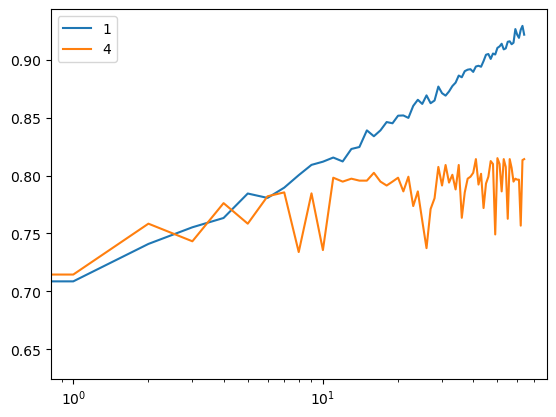

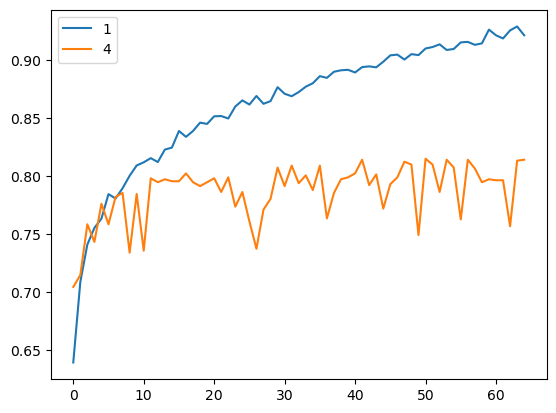

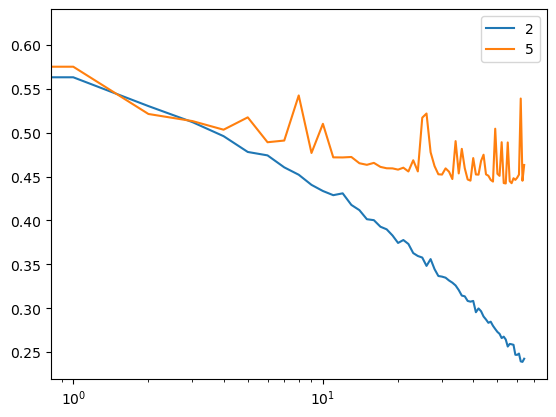

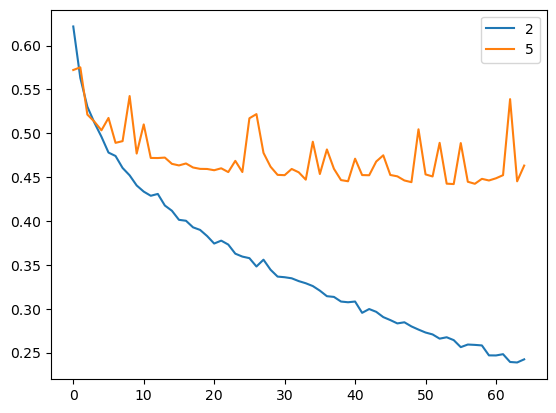

In [10]:
# Seems like the model is overfitting for 3500/1350 units therefore we can try
# adding dropout layers, although the references say its more a parameter missing problem
import pandas
metrics_df1 = pandas.read_csv("data/3500-1350_no_aug/out_3500-1350.csv", sep=',', header=None)
metrics_df1[[1, 4]].plot(logx=True)
metrics_df1[[1, 4]].plot(logx=False)
metrics_df1[[2, 5]].plot(logx=True)
metrics_df1[[2, 5]].plot(logx=False)

In [11]:
metrics_df1

,0,1,2,3,4,5,6
0,0,0.639130,0.621690,15.698115,0.704392,0.572083,15.819257
1,1,0.708641,0.563106,15.659001,0.714527,0.575155,16.131756
2,2,0.740968,0.530292,15.631072,0.758446,0.521297,15.641891
3,3,0.755335,0.512042,15.460537,0.743243,0.513214,15.381757
4,4,0.763364,0.496016,15.546613,0.776182,0.503380,15.831081
...,...,...,...,...,...,...,...
60,60,0.921614,0.246812,15.504063,0.796453,0.448704,15.293919
61,61,0.918868,0.248255,15.401750,0.796453,0.452246,15.511825
62,62,0.925840,0.239364,15.426622,0.756757,0.538898,16.097973
63,63,0.929220,0.238806,15.467658,0.813345,0.445237,15.658784


In [16]:
# It looks like we have a serious case of underfitting?

# Second Experiment


In [ ]:
first_layer_units = 700
second_layer_units = 250

# Optimizer: DeltaGrad
# To me it looks like we are overfitting.

<Axes: >

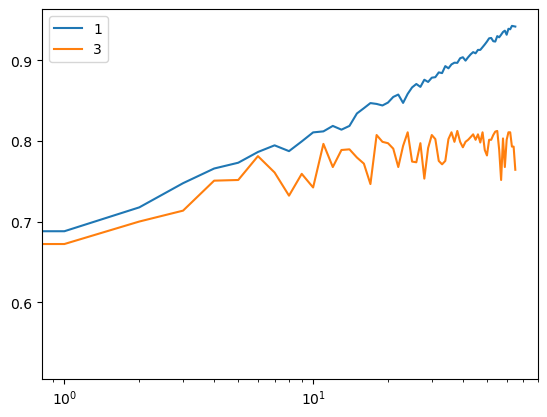

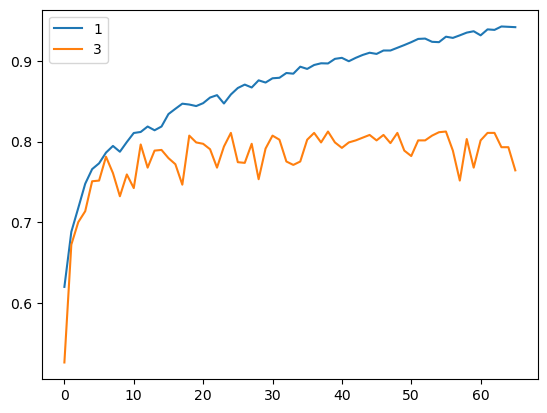

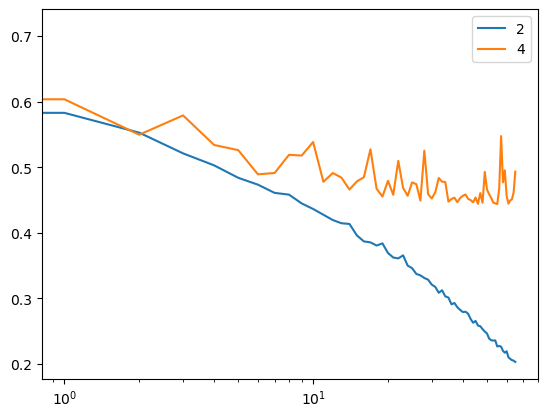

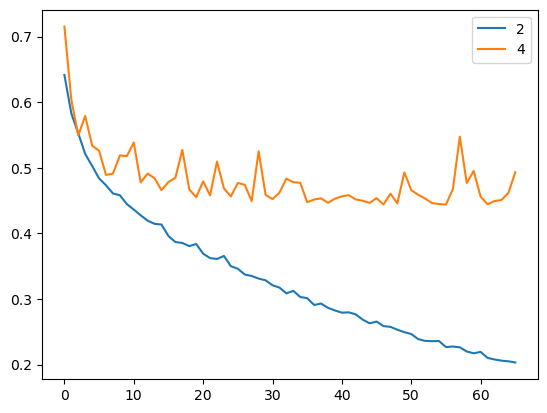

In [12]:
# Seems like the model is overfitting for 3500/1350 units therefore we can try
# adding dropout layers, although the references say its more a parameter missing problem
import pandas
metrics_df1 = pandas.read_csv("data/700-250-no-aug/out.csv", sep=',', header=None)
metrics_df1[[1, 3]].plot(logx=True)
metrics_df1[[1, 3]].plot(logx=False)
metrics_df1[[2, 4]].plot(logx=True)
metrics_df1[[2, 4]].plot(logx=False)